# HierE2E Favorita Baseline

This notebook runs and evaluates HierE2E's baseline method predictions for the Favorita dataset.

- It reads a preprocessed Favorita dataset.
- It fits a HierE2E's model.
- It evaluates HierE2E forecasts' sCRPS and MSSE.

## References
- [GluonTS, DeepVARHierarchicalEstimator](https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.model.deepvar_hierarchical.html?highlight=deepvarhierarchicalestimator#gluonts.mx.model.deepvar_hierarchical.DeepVARHierarchicalEstimator)
- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series. Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)


<br>
You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/experiments/hierarchical_baselines/nbs/run_favorita_hiere2e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install mxnet-cu112

In [2]:
import mxnet as mx

assert mx.context.num_gpus()>0

In [3]:
%%capture
!pip install "gluonts[mxnet,pro]"
!pip install git+https://github.com/Nixtla/hierarchicalforecast.git
!pip install git+https://github.com/Nixtla/datasetsforecast.git@feat/favorita_dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.mx.trainer import Trainer
from gluonts.dataset.hierarchical import HierarchicalTimeSeries
from gluonts.dataset.common import Dataset, ListDataset
from gluonts.mx.model.deepvar_hierarchical import DeepVARHierarchicalEstimator

from hierarchicalforecast.evaluation import scaled_crps, rel_mse, msse
from datasetsforecast.favorita import FavoritaData, FavoritaInfo

import warnings
# Avoid pandas fragmentation warning and positive definite warning
warnings.filterwarnings("ignore")

### Package Versions

In [33]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [34]:
!nvidia-smi

Tue Jun 27 16:08:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |   8197MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
import gluonts

print('mx.__version__', mx.__version__)
print('gluonts.__version__', gluonts.__version__)

mx.__version__ 1.9.1
gluonts.__version__ 0.13.2


## Auxiliary Functions

In [5]:
# Slight modifications of evaluation metrics to operate with tensors
# https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/evaluation.py
from typing import Optional, Union

def _metric_protections(y: np.ndarray, y_hat: np.ndarray,
                        weights: Optional[np.ndarray]) -> None:
    if not ((weights is None) or (np.sum(weights) > 0)):
        raise Exception('Sum of `weights` cannot be 0')
    if not ((weights is None) or (weights.shape == y.shape)):
        raise Exception(
        f'Wrong weight dimension weights.shape {weights.shape}, y.shape {y.shape}')

def mse(y: np.ndarray, y_hat: np.ndarray,
        weights: Optional[np.ndarray] = None,
        axis: Optional[int] = None) -> Union[float, np.ndarray]:
    _metric_protections(y, y_hat, weights)

    delta_y = np.square(y - y_hat)
    if weights is not None:
        mse = np.average(delta_y[~np.isnan(delta_y)],
                         weights=weights[~np.isnan(delta_y)],
                         axis=axis)
    else:
        mse = np.nanmean(delta_y, axis=axis)
    return mse

def rel_mse(y, y_hat, y_train, mask=None):
    if mask is None:
       mask = np.ones_like(y)
    n_series, n_hier, horizon = y.shape

    eps = np.finfo(float).eps
    y_naive = np.repeat(y_train[:,:,[-1]], horizon, axis=2)
    norm = mse(y=y, y_hat=y_naive)
    loss = mse(y=y, y_hat=y_hat, weights=mask)
    loss = loss / (norm + eps)
    return loss

# %% ../nbs/evaluation.ipynb 11
def msse(y, y_hat, y_train, mask=None):
    if mask is None:
       mask = np.ones_like(y)
    n_series, n_hier, horizon = y.shape

    eps = np.finfo(float).eps
    y_in_sample_naive = y_train[:, :, :-1]
    y_in_sample_true = y_train[:, :, 1:]
    norm = mse(y=y_in_sample_true, y_hat=y_in_sample_naive)
    loss = mse(y=y, y_hat=y_hat, weights=mask)
    loss = loss / (norm + eps)
    return loss

In [36]:
class FavoritaHierarchicalDataset(object):
    # Class with loading, processing and
    # prediction evaluation methods for hierarchical data

    available_datasets = ['Favorita200', 'Favorita500', 'FavoritaComplete']

    @staticmethod
    def _get_hierarchical_scrps(hier_idxs, Y, Yq_hat, q_to_pred):
        # We use the indexes obtained from the aggregation tags
        # to compute scaled CRPS across the hierarchy levels
        # # [n_items, n_stores, n_time, n_quants]
        scrps_list = []
        for idxs in hier_idxs:
            y      = Y[:, idxs, :]
            yq_hat = Yq_hat[:, idxs, :, :]
            scrps  = scaled_crps(y, yq_hat, q_to_pred)
            scrps_list.append(scrps)
        return scrps_list

    @staticmethod
    def _get_hierarchical_msse(hier_idxs, Y, Y_hat, Y_train):
        # We use the indexes obtained from the aggregation tags
        # to compute scaled CRPS across the hierarchy levels
        msse_list = []
        for idxs in hier_idxs:
            y       = Y[:, idxs, :]
            y_hat   = Y_hat[:, idxs, :]
            y_train = Y_train[:, idxs, :]
            crps    = msse(y, y_hat, y_train)
            msse_list.append(crps)
        return msse_list

    @staticmethod
    def _get_hierarchical_rel_mse(hier_idxs, Y, Y_hat, Y_train):
        # We use the indexes obtained from the aggregation tags
        # to compute relative MSE across the hierarchy levels
        rel_mse_list = []
        for idxs in hier_idxs:
            y       = Y[:,idxs, :]
            y_hat   = Y_hat[:,idxs, :]
            y_train = Y_train[:,idxs, :]
            level_rel_mse = rel_mse(y, y_hat, y_train)
            rel_mse_list.append(level_rel_mse)
        return rel_mse_list

    @staticmethod
    def _sort_hier_df(Y_df, S_df):
        # NeuralForecast core, sorts unique_id lexicographically
        # deviating from S_df, this class matches S_df and Y_hat_df order.
        Y_df.unique_id = Y_df.unique_id.astype('category')
        Y_df.unique_id = Y_df.unique_id.cat.set_categories(S_df.index)
        Y_df = Y_df.sort_values(by=['unique_id', 'ds'])
        return Y_df

    @staticmethod
    def _nonzero_indexes_by_row(M):
        return [np.nonzero(M[row,:])[0] for row in range(len(M))]

    @staticmethod
    def load_item_data(item_id, dataset='Favorita200', directory='./data'):
        # Load data
        data_info = FavoritaInfo[dataset]
        Y_df, S_df, tags = FavoritaData.load(directory=directory,
                                             group=dataset)

        # Parse and augment data
        # + hack geographic hier_id to treat it as unique_id
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        Y_df = Y_df[Y_df.item_id==item_id]
        Y_df = Y_df.rename(columns={'hier_id': 'unique_id'})
        Y_df = FavoritaHierarchicalDataset._sort_hier_df(Y_df=Y_df, S_df=S_df)

        # Obtain indexes for plots and evaluation
        hier_levels = ['Overall'] + list(tags.keys())
        hier_idxs = [np.arange(len(S_df))] +\
            [S_df.index.get_indexer(tags[level]) for level in list(tags.keys())]
        hier_linked_idxs = FavoritaHierarchicalDataset._nonzero_indexes_by_row(S_df.values.T)

        # MinT along other methods require a positive definite covariance matrix
        # for the residuals, when dealing with 0s as residuals the methods break
        # data is augmented with minimal normal noise to avoid this error.
        Y_df['y'] = Y_df['y'] + np.random.normal(loc=0.0, scale=0.01, size=len(Y_df))

        # Final output
        data = dict(Y_df=Y_df, S_df=S_df, tags=tags,
                    # Hierarchical idxs
                    hier_idxs=hier_idxs,
                    hier_levels=hier_levels,
                    hier_linked_idxs=hier_linked_idxs,
                    # Dataset Properties
                    horizon=data_info.horizon,
                    freq=data_info.freq,
                    seasonality=data_info.seasonality)
        return data

    @staticmethod
    def load_process_data(dataset='Favorita200', directory='./data',
                          is_validation=False):
        # Load data
        data_info = FavoritaInfo[dataset]
        Y_df, S_df, tags = FavoritaData.load(directory='./data/favorita',
                                             group=dataset)

        # Obtain indexes for plots and evaluation
        hier_levels = ['Overall'] + list(tags.keys())
        hier_idxs = [np.arange(len(S_df))] +\
            [S_df.index.get_indexer(tags[level]) for level in list(tags.keys())]
        hier_linked_idxs = \
            FavoritaHierarchicalDataset._nonzero_indexes_by_row(S_df.values.T)

        # Parse data
        Y_df['unique_id'] = Y_df['hier_id'] + '_' + Y_df['item_id'].astype(str)
        dates = Y_df.ds.unique() # already sorted
        n_items = len(Y_df.item_id.unique())
        n_hier  = len(Y_df.hier_id.unique())
        n_dates = len(Y_df.ds.unique())

        # MinT along other methods require a positive definite covariance matrix
        # for the residuals, when dealing with 0s as residuals the methods break
        # data is augmented with minimal normal noise to avoid this error.
        np.random.seed(0)
        Y_hier = Y_df.y.values
        Y_hier = Y_hier + np.random.normal(loc=0.0, scale=0.01,
                                           size=len(Y_hier))
        Y_hier = np.reshape(Y_hier, (n_items, n_hier, n_dates))

        # Declare GluonTS dataloaders.
        horizon = data_info.horizon
        freq = data_info.freq

        if is_validation:
            target_train = Y_hier[:, :, :len(dates) - 2 * horizon]
            target_test = Y_hier[:, :, :len(dates) - horizon]
            valid_plus_test_length = 2 * horizon
            valid_length = horizon
        else:
            target_train = Y_hier[:, :, :len(dates) - horizon]
            target_test = Y_hier
            valid_plus_test_length = horizon
            valid_length = 0

        training_data = ListDataset(
            [{"start":dates[0], "item_id": "all_items", \
              "target": target_train[idx,:,:]} for idx in range(n_items)],
            freq=freq,
            one_dim_target=False
        )
        testing_data = ListDataset(
            [{"start": dates[0], "item_id": "all_items", \
              "target": target_test[idx,:,:]} for idx in range(n_items)],
            freq=freq,
            one_dim_target=False
        )

        # Final output
        data = dict(Y_df=Y_df, S_df=S_df, tags=tags,
                    Y_hier=Y_hier,
                    training_data=training_data, testing_data=testing_data,
                    # Hierarchical idxs
                    hier_idxs=hier_idxs,
                    hier_levels=hier_levels,
                    hier_linked_idxs=hier_linked_idxs,
                    # Dataset Properties
                    horizon=data_info.horizon,
                    freq=data_info.freq,
                    seasonality=data_info.seasonality)
        return data

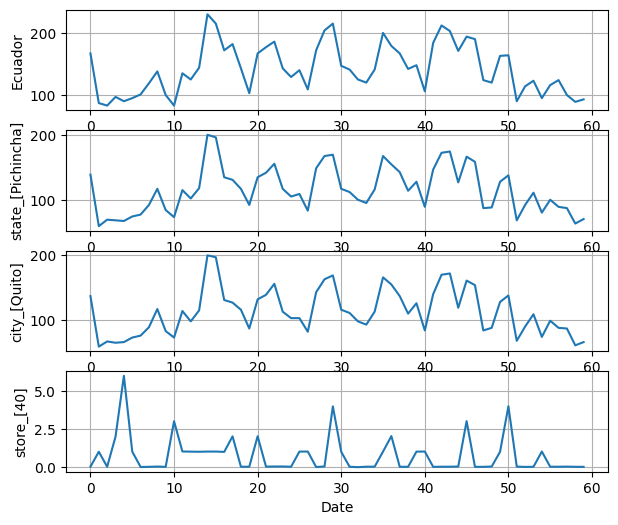

In [37]:
# Testing load and plotting series
data = FavoritaHierarchicalDataset.load_process_data(directory='./data/favorita',
                                                 dataset='Favorita200',
                                                 is_validation=False)

item_idx = 0
store_idx = 39
Y_plot = data['Y_hier'][item_idx,:,:]
hier_idxs = data['hier_linked_idxs'][store_idx]

fig, axs = plt.subplots(nrows=4, figsize=(7, 6))
for i, hier_idx in enumerate(hier_idxs):
    axs[i].plot(Y_plot[hier_idx, -60:])
    axs[i].set_ylabel(data['S_df'].index[hier_idx])
    axs[i].grid()
axs[i].set_xlabel('Date')
plt.show()

## Fit/Predict HierE2E

In [38]:
def run_hiere2e(config, data):

    estimator = DeepVARHierarchicalEstimator(
        freq=data['freq'],
        prediction_length=data['horizon'],
        target_dim=len(data['S_df']),
        S=data['S_df'].values,
        trainer=Trainer(ctx = mx.context.gpu(),
                        epochs=config['epochs'],
                        num_batches_per_epoch=config['num_batches_per_epoch'],
                        hybridize=config['hybridize'],
                        learning_rate=config['learning_rate']),
        scaling=config['scaling'],
        pick_incomplete=config['pick_incomplete'],
        batch_size=config['batch_size'],
        num_parallel_samples=config['num_parallel_samples'],
        context_length=config['context_length'],
        num_layers=config['num_layers'],
        num_cells=config['num_cells'],
        coherent_train_samples=config['coherent_train_samples'],
        coherent_pred_samples=config['coherent_pred_samples'],
        likelihood_weight=config['likelihood_weight'],
        CRPS_weight=config['CRPS_weight'],
        num_samples_for_loss=config['num_samples_for_loss'],
        sample_LH=config['sample_LH'],
        seq_axis=config['seq_axis'],
        warmstart_epoch_frac = config['warmstart_epoch_frac'],
    )

    predictor = estimator.train(training_data=data['training_data'])
    forecast_it = predictor.predict(dataset=data['training_data'])

    # Generate samples for empirical quantiles
    samples_list = []
    for step in forecast_it:
        samples = step.samples
        samples_list.append(samples[None,:,:,:])

    # [n_items, n_samples, horizon, n_hier] 0,1,2,3
    # -> [n_items, n_hier, horizon, n_samples] 0,3,2,1
    samples = np.concatenate(samples_list, axis=0)
    samples = np.transpose(samples, (0,3,2,1))

    Y_hat  = np.mean(samples, axis=3)
    Yq_hat = np.quantile(samples, q=QUANTILES, axis=3)
    Yq_hat = np.transpose(Yq_hat, (1,2,3,0))

    Y_test = data['Y_hier'][:,:,-data['horizon']:]
    Y_train = data['Y_hier'][:,:,:-data['horizon']]

    print('\n')
    print('Yq_hat.shape: \t', Yq_hat.shape)
    print('Y_hat.shape: \t', Y_hat.shape)
    print('Y_test.shape: \t', Y_test.shape)
    print('Y_train.shape: \t', Y_train.shape)

    return Yq_hat, Y_hat, Y_test, Y_train

In [53]:
# Optimal parameters reported from IJF 2023 code
# hyperopt hyperparameter selection previously performed over:
# learning rate hp.loguniform('learning_rate', np.log(5e-5), np.log(0.001))
# epochs scope.int(hp.quniform('epochs', 10, 25, 5))
# Gaussian augmentation for MinTrace numeric stability is strongly recommended
config = dict(epochs=25,
              num_batches_per_epoch=50,
              scaling=True,
              pick_incomplete=False,
              batch_size=32,
              num_parallel_samples=200,
              hybridize=False,
              learning_rate=0.0005, # 0.0005 0.64
              context_length=24,
              rank=4,
              assert_reconciliation=False,
              num_deep_models=1,
              num_layers=2,
              num_cells=40,
              coherent_train_samples=True,
              coherent_pred_samples=True,
              likelihood_weight=0.0,       # Likelihood training is unstable
              CRPS_weight=1.0,             # CRPS training is stable
              num_samples_for_loss=50,     # Reduce for speed boost
              sample_LH=True,
              seq_axis=[1],
              warmstart_epoch_frac=0.1
)

In [54]:
DATASET = 'Favorita200' # 'Favorita500', 'FavoritaComplete'
is_validation = False

LEVEL = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
QUANTILES = np.sort(np.concatenate(qs)/100)

data = FavoritaHierarchicalDataset.load_process_data(directory='./data/favorita',
                                                 dataset=DATASET,
                                                 is_validation=is_validation)

Yq_hat, Y_hat, Y_test, Y_train = run_hiere2e(config=config, data=data)

100%|██████████| 50/50 [00:19<00:00,  2.53it/s, epoch=25/25, avg_epoch_loss=5.22e+3]




Yq_hat.shape: 	 (200, 93, 34, 100)
Y_hat.shape: 	 (200, 93, 34)
Y_test.shape: 	 (200, 93, 34)
Y_train.shape: 	 (200, 93, 193)


## Evaluate HierE2E

To evaluate we use the following metrics:

A scaled variation of the CRPS, as proposed by Rangapuram (2021), to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

$$ \mathrm{sCRPS}(\hat{F}_{\tau}, \mathbf{y}_{\tau}) = \frac{2}{N} \sum_{i}
\int^{1}_{0}
\frac{\mathrm{QL}(\hat{F}_{i,\tau}, y_{i,\tau})_{q}}{\sum_{i} | y_{i,\tau} |} dq $$


Relative mean squared error (RelMSE), as proposed by Hyndman & Koehler (2006) and used in Olivares (2023).

$$ \mathrm{RelMSE}(\mathbf{y}, \mathbf{\hat{y}}, \mathbf{\hat{y}}^{naive1}) =
\frac{\mathrm{MSE}(\mathbf{y}, \mathbf{\hat{y}})}{\mathrm{MSE}(\mathbf{y}, \mathbf{\hat{y}}^{naive1})} $$

Mean squared scaled error (MSSE), as proposed by Hyndman & Koehler (2006).

$$ \mathrm{MSSE}(\mathbf{y}, \mathbf{\hat{y}}, \mathbf{y}^{in-sample}) =
\frac{\frac{1}{h} \sum^{t+h}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^2}{\frac{1}{t-1} \sum^{t}_{\tau=2} (y_{\tau} - y_{\tau-1})^2}
$$

In [55]:
# Final sCRPS and MSSE evaluation
_scrps = FavoritaHierarchicalDataset._get_hierarchical_scrps(
                                            Y=Y_test, Yq_hat=Yq_hat,
                                            hier_idxs=data['hier_idxs'],
                                            q_to_pred=QUANTILES)

_rel_mse = FavoritaHierarchicalDataset._get_hierarchical_rel_mse(
                                           Y=Y_test, Y_hat=Y_hat,
                                           Y_train=Y_train,
                                           hier_idxs=data['hier_idxs'])

_msse = FavoritaHierarchicalDataset._get_hierarchical_msse(
                                           Y=Y_test, Y_hat=Y_hat,
                                           Y_train=Y_train,
                                           hier_idxs=data['hier_idxs'])

results_df = pd.DataFrame(dict(level=['Overall']+list(data['tags'].keys())))
results_df['scrps'] = _scrps
results_df['rel_mse'] = _rel_mse
results_df['msse'] = _msse
results_df

,level,scrps,rel_mse,msse
0,Overall,0.521458,3.041768,4.973758
1,Country,0.421504,3.021425,6.230773
2,Country/State,0.507045,3.285278,4.442620
3,Country/State/City,0.537503,3.231190,4.311465
4,Country/State/City/Store,0.619670,1.695264,2.329531


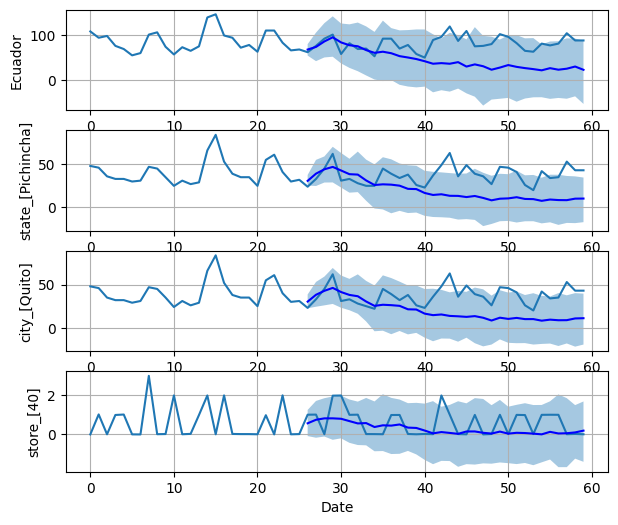

In [56]:
item_idx = 2
store_idx = 39
Y_plot = data['Y_hier'][item_idx,:,:]
hier_idxs = data['hier_linked_idxs'][store_idx]

dates = np.arange(60)

fig, axs = plt.subplots(nrows=4, figsize=(7, 6))
for i, hier_idx in enumerate(hier_idxs):
    axs[i].plot(dates, Y_plot[hier_idx, -60:])

    axs[i].plot(dates[-34:], Y_hat[item_idx, hier_idx, :], color='blue')
    axs[i].fill_between(x=dates[-34:],
                        y1=Yq_hat[item_idx, hier_idx, :, 4],
                        y2=Yq_hat[item_idx, hier_idx, :, -5],
                        alpha=0.4, label='level 90')

    axs[i].set_ylabel(data['S_df'].index[hier_idx])
    axs[i].grid()
axs[i].set_xlabel('Date')
plt.show()